In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp])  # https://docs.fast.ai/optimizer
    # model parameters
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x2757daaa348>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x2757daaa988>,
 'lr': <hyperopt.pyll.base.Apply at 0x2757daa5108>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2757daa5708>,
 'patience': <hyperopt.pyll.base.Apply at 0x2757daa5c88>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2757daa72c8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

212

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = OmniScaleCNN
        k = {}
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
  3%|██▏                                                                | 1/30 [00:52<13:06, 27.10s/trial, best loss=?]

epoch,train_loss,valid_loss,accuracy,time


Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
  7%|████▍                                                              | 2/30 [01:19<12:41, 27.21s/trial, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,0.934686,0.924121,0.669369,00:48
1,0.915672,0.905370,0.682013,00:46
2,0.888079,0.876473,0.679359,00:47
3,0.863151,1.170125,0.575600,00:47
4,0.833288,1.056442,0.671831,00:47
5,0.797571,0.965879,0.665991,00:47
6,0.762940,1.019855,0.636359,00:47
7,0.729994,1.087693,0.673085,00:47


No improvement since epoch 2: early stopping                                                                           
  7%|████▍                                                              | 2/30 [07:39<12:41, 27.21s/trial, best loss=?]

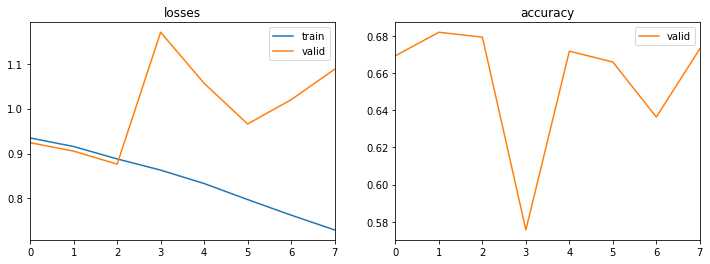

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 10, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 10%|████▌                                         | 3/30 [08:05<1:03:20, 140.74s/trial, best loss: 1.0876928567886353]

epoch,train_loss,valid_loss,accuracy,time


Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 10, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 13%|██████▍                                         | 4/30 [08:30<45:58, 106.10s/trial, best loss: 1.0876928567886353]

epoch,train_loss,valid_loss,accuracy,time
0,0.980324,0.981988,0.661165,00:26
1,0.946012,1.098602,0.661985,00:25
2,0.918589,0.924082,0.676367,00:25
3,0.871362,0.928552,0.676801,00:25
4,0.808605,1.094797,0.673906,00:25
5,0.704934,1.222387,0.664543,00:25
6,0.608361,1.185224,0.660007,00:25
7,0.501054,1.246539,0.629217,00:25
8,0.421156,1.276886,0.639544,00:25
9,0.385177,1.300882,0.640075,00:25


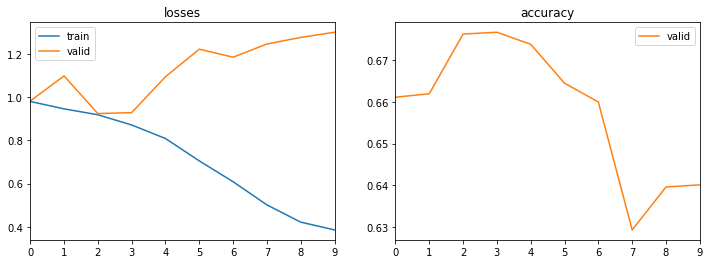

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 10, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 17%|███████▋                                      | 5/30 [13:08<1:05:38, 157.55s/trial, best loss: 1.0876928567886353]

epoch,train_loss,valid_loss,accuracy,time
0,0.942479,0.928172,0.665267,00:47
1,0.915060,0.905078,0.679118,00:47
2,0.904818,1.020517,0.632595,00:48
3,0.883275,1.088772,0.659958,00:48
4,0.852376,1.113777,0.678394,00:48
5,0.825772,1.558742,0.660538,00:47
6,0.802147,1.179028,0.670334,00:48
7,0.767849,1.128350,0.678973,00:47
8,0.723415,1.478383,0.441243,00:47
9,0.674635,1.337536,0.647604,00:48


No improvement since epoch 1: early stopping                                                                           
 17%|███████▋                                      | 5/30 [22:43<1:05:38, 157.55s/trial, best loss: 1.0876928567886353]

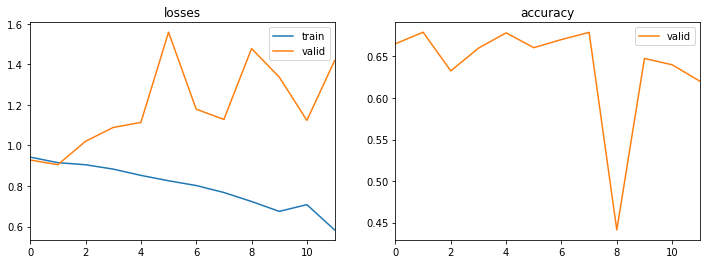

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.01, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 23%|██████████▋                                   | 7/30 [23:33<1:20:50, 210.90s/trial, best loss: 1.0876928567886353]

epoch,train_loss,valid_loss,accuracy,time


Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 27%|████████████▊                                   | 8/30 [23:59<56:54, 155.19s/trial, best loss: 1.0876928567886353]

epoch,train_loss,valid_loss,accuracy,time
0,0.952410,0.967530,0.654939,00:26
1,0.937281,0.941427,0.662661,00:26
2,0.905509,0.945448,0.666039,00:26
3,0.902221,0.926612,0.673423,00:26
4,0.885854,0.909865,0.682786,00:28
5,0.872306,0.937136,0.671348,00:27
6,0.848814,1.081545,0.665846,00:26
7,0.841063,1.022788,0.636504,00:27
8,0.806399,0.944095,0.665750,00:27
9,0.789942,1.121473,0.669852,00:27


No improvement since epoch 4: early stopping                                                                           
 27%|████████████▊                                   | 8/30 [28:29<56:54, 155.19s/trial, best loss: 1.0876928567886353]

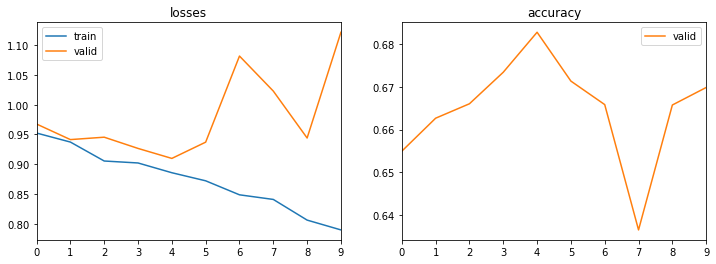

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 5, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 't

epoch,train_loss,valid_loss,accuracy,time
0,1.299630,1.327958,0.600550,00:49
1,1.170658,1.188248,0.623908,00:49
2,1.083647,1.060887,0.645191,00:49
3,1.009218,1.007173,0.653299,00:49
4,0.972101,0.970559,0.654746,00:50
5,0.944053,0.956635,0.659331,00:50
6,0.926605,0.931214,0.665364,00:49
7,0.914376,0.923374,0.667439,00:49
8,0.902424,0.913410,0.667728,00:51
9,0.891835,0.918739,0.663095,00:50


No improvement since epoch 10: early stopping                                                                          
 40%|███████████████████▏                            | 12/30 [43:53<26:04, 86.92s/trial, best loss: 1.0876928567886353]

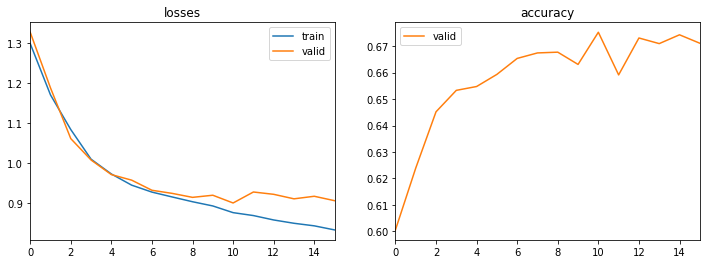

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 10, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 43%|███████████████████▌                         | 13/30 [44:18<1:28:24, 312.04s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,0.972360,0.914121,0.666811,00:48
1,0.957112,0.909279,0.670914,00:49
2,0.949583,0.926581,0.665122,00:49
3,0.904730,0.848792,0.686260,00:49
4,0.868383,0.983776,0.663288,00:49
5,0.803062,0.933093,0.660152,00:49
6,0.736242,0.953229,0.662178,00:49
7,0.660939,1.081104,0.613870,00:49
8,0.612211,1.090184,0.651272,00:49
9,0.591812,1.118028,0.654795,00:49


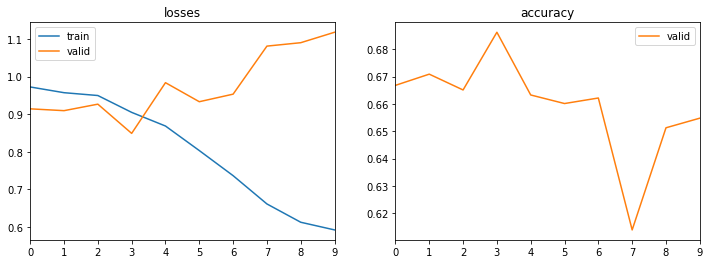

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 10, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 10, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 50%|██████████████████████▌                      | 15/30 [53:20<1:07:14, 268.98s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,0.924959,0.923228,0.668694,00:48
1,0.892610,0.888680,0.676946,00:50
2,0.844323,0.856892,0.683509,00:51
3,0.763000,1.005829,0.659524,00:51
4,0.683683,1.117177,0.663916,00:51
5,0.597239,1.179039,0.658897,00:51
6,0.509376,1.345304,0.673085,00:51
7,0.433202,1.176537,0.650934,00:51
8,0.371997,1.248015,0.657304,00:51
9,0.339768,1.243231,0.660200,00:51


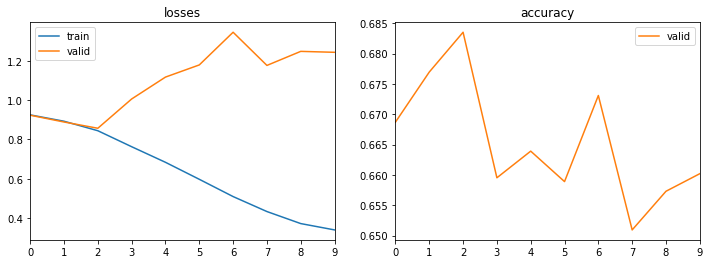

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000274E06BB1F8>, 'patience': 10, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 53%|██████████████████████▉                    | 16/30 [1:02:20<1:21:23, 348.85s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,1.016439,0.980729,0.663385,00:27
1,0.939381,0.953976,0.659814,00:28
2,0.920735,1.005048,0.663771,00:28
3,0.908669,0.946377,0.661744,00:29
4,0.880079,0.939789,0.669418,00:28
5,0.864006,0.930797,0.669611,00:29
6,0.846618,0.936814,0.673954,00:28
7,0.838652,0.945533,0.675402,00:29
8,0.820193,0.944449,0.673761,00:29
9,0.826177,0.942152,0.675450,00:29


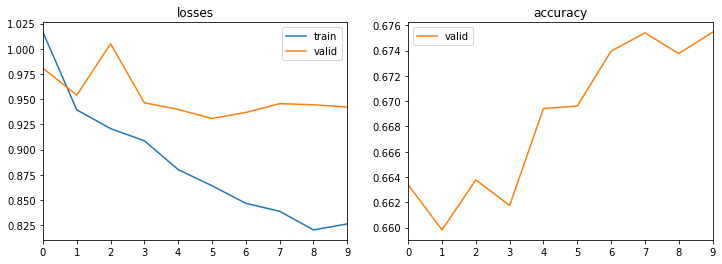

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.001, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 10, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.0001, 'optimizer': <function SGD at 0x00000274E06BB0D8>, 'patience': 10, 'time_steps': 90}
Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 63%|████████████████████████████▌                | 19/30 [1:08:34<33:05, 180.50s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,0.940121,0.961874,0.675016,00:25
1,0.926747,0.971601,0.654264,00:26
2,0.875210,1.012838,0.680566,00:26
3,0.819341,0.997160,0.658366,00:26
4,0.729603,1.236746,0.670527,00:26
5,0.639396,1.146711,0.666570,00:27


No improvement since epoch 0: early stopping                                                                           
 63%|████████████████████████████▌                | 19/30 [1:11:13<33:05, 180.50s/trial, best loss: 0.9050619602203369]

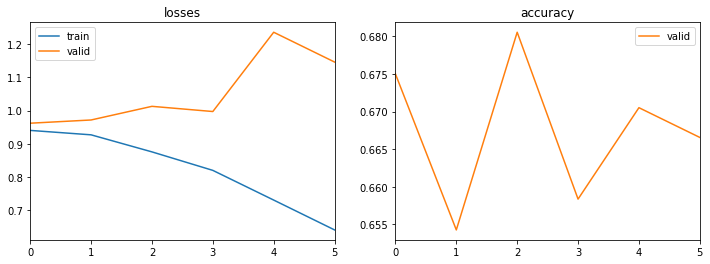

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 10, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 67%|██████████████████████████████               | 20/30 [1:11:39<30:31, 183.10s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,1.289459,1.302478,0.600743,00:26
1,1.070286,1.082050,0.637904,00:27
2,0.991645,0.995399,0.658655,00:28
3,0.960293,0.958616,0.668790,00:28
4,0.937266,0.961137,0.666184,00:28
5,0.936199,0.930948,0.669466,00:28
6,0.922355,0.950177,0.661261,00:28
7,0.909001,0.944722,0.664543,00:28
8,0.900275,0.942950,0.665653,00:29
9,0.898194,0.999325,0.623039,00:28


No improvement since epoch 12: early stopping                                                                          
 67%|██████████████████████████████               | 20/30 [1:22:46<30:31, 183.10s/trial, best loss: 0.9050619602203369]

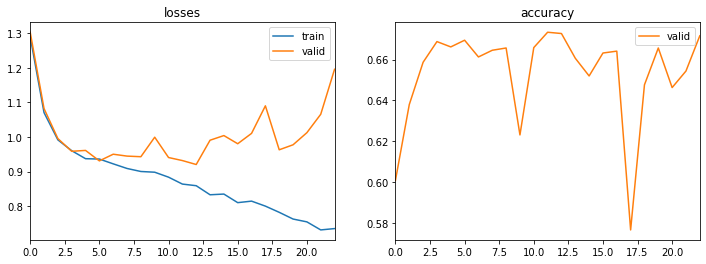

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 10, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 70%|███████████████████████████████▍             | 21/30 [1:23:15<50:26, 336.25s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,1.160993,1.181222,0.623329,00:27
1,1.022800,1.020284,0.657739,00:28
2,0.973670,0.984800,0.663675,00:29
3,0.952041,0.978915,0.658607,00:29
4,0.933793,0.973853,0.659669,00:28
5,0.930194,0.964304,0.655808,00:29
6,0.913595,0.957723,0.663530,00:29
7,0.916225,0.965347,0.657932,00:29
8,0.909035,0.960421,0.669080,00:29
9,0.882987,0.950862,0.661310,00:29


No improvement since epoch 10: early stopping                                                                          
 70%|███████████████████████████████▍             | 21/30 [1:33:38<50:26, 336.25s/trial, best loss: 0.9050619602203369]

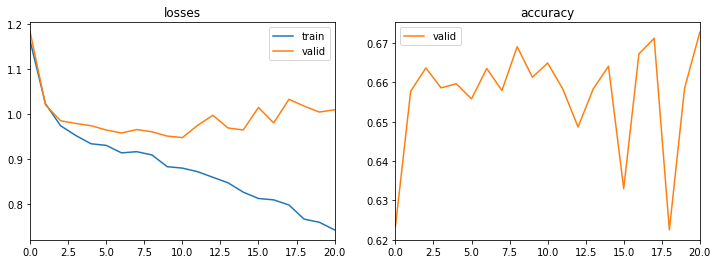

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 10, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 73%|█████████████████████████████████            | 22/30 [1:34:08<57:26, 430.82s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,1.292329,1.327197,0.584721,00:27
1,1.070834,1.081100,0.644515,00:28
2,0.993230,0.999258,0.659283,00:29
3,0.966661,0.979134,0.660827,00:29
4,0.943756,0.979634,0.656629,00:29
5,0.931933,0.990893,0.659910,00:30
6,0.919257,0.944679,0.665315,00:30
7,0.921742,0.976329,0.660875,00:30
8,0.908840,0.952386,0.661117,00:29
9,0.903897,0.995435,0.640075,00:29


No improvement since epoch 14: early stopping                                                                          
 73%|█████████████████████████████████            | 22/30 [1:46:35<57:26, 430.82s/trial, best loss: 0.9050619602203369]

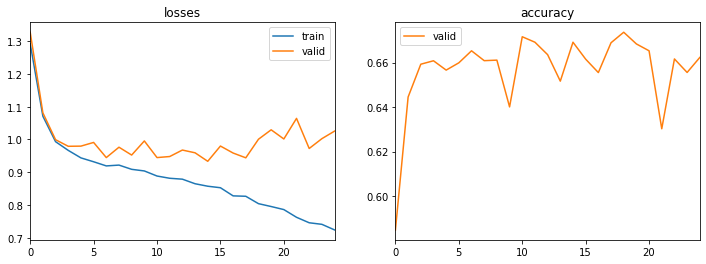

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 30}
OmniScaleCNN                                                                                                           
 77%|████████████████████████████████▉          | 23/30 [1:47:04<1:02:22, 534.65s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,1.198103,1.070451,0.640461,00:26
1,0.955582,0.988381,0.656725,00:27
2,0.915328,0.944703,0.665991,00:28
3,0.905298,0.910989,0.677911,00:28
4,0.889387,0.936960,0.666811,00:28
5,0.875456,0.918375,0.665364,00:28
6,0.859218,0.937901,0.671493,00:28
7,0.845812,0.925792,0.670479,00:28
8,0.838030,0.930442,0.670093,00:29


No improvement since epoch 3: early stopping                                                                           
 77%|████████████████████████████████▉          | 23/30 [1:51:17<1:02:22, 534.65s/trial, best loss: 0.9050619602203369]

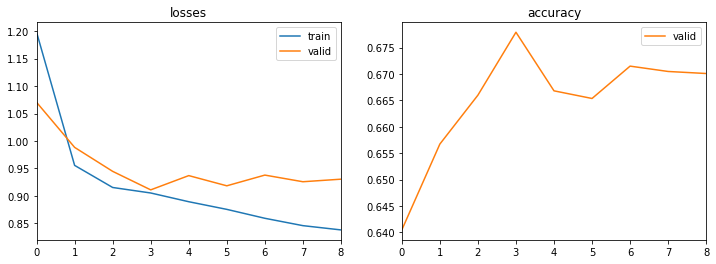

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 80%|████████████████████████████████████         | 24/30 [1:51:48<45:54, 459.06s/trial, best loss: 0.9050619602203369]

epoch,train_loss,valid_loss,accuracy,time
0,1.200047,1.135406,0.656194,00:51
1,0.971284,0.995996,0.658269,00:53
2,0.907397,0.931878,0.672796,00:53
3,0.886592,0.909020,0.676222,00:53
4,0.864075,0.887200,0.675691,00:53
5,0.858940,0.889794,0.678056,00:53
6,0.834919,0.878292,0.678249,00:54
7,0.821862,0.889175,0.677332,00:54
8,0.819628,0.881946,0.677380,00:53
9,0.818444,0.879127,0.679118,00:53


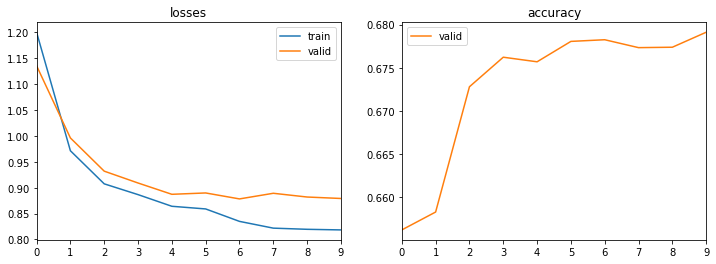

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 83%|█████████████████████████████████████▌       | 25/30 [2:01:09<40:54, 490.94s/trial, best loss: 0.8791267275810242]

epoch,train_loss,valid_loss,accuracy,time
0,1.510166,1.519701,0.566575,00:50
1,1.343310,1.366901,0.602432,00:52
2,1.205333,1.215806,0.630134,00:52
3,1.095078,1.090984,0.646976,00:53
4,1.014088,1.023898,0.656532,00:55
5,0.958666,0.962175,0.668018,00:55
6,0.925850,0.949231,0.668018,00:54
7,0.902750,0.951035,0.668790,00:54
8,0.886568,0.925816,0.668018,00:54
9,0.878130,0.932962,0.667535,00:55


No improvement since epoch 14: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [2:19:09<40:54, 490.94s/trial, best loss: 0.8791267275810242]

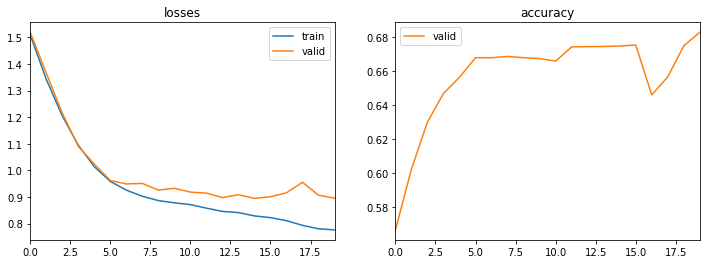

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 87%|███████████████████████████████████████      | 26/30 [2:19:40<45:02, 675.68s/trial, best loss: 0.8791267275810242]

epoch,train_loss,valid_loss,accuracy,time
0,1.186801,1.191155,0.613532,00:50
1,0.958727,0.933336,0.667825,00:52
2,0.905760,0.934845,0.662468,00:52
3,0.881569,0.916518,0.664640,00:52
4,0.864834,0.908089,0.667535,00:53
5,0.841634,0.890287,0.671107,00:53
6,0.827324,0.896845,0.671058,00:53
7,0.813410,0.894699,0.675740,00:53
8,0.814969,0.902274,0.670190,00:53
9,0.807511,0.898004,0.673906,00:54


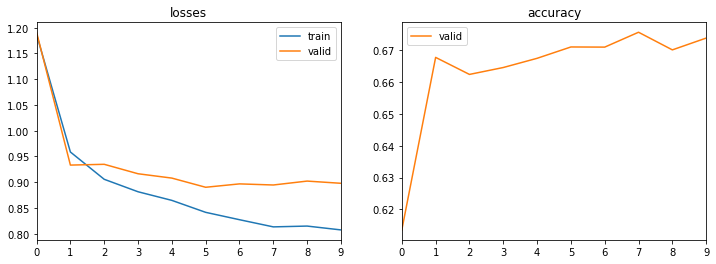

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 90%|████████████████████████████████████████▌    | 27/30 [2:28:59<32:03, 641.07s/trial, best loss: 0.8791267275810242]

epoch,train_loss,valid_loss,accuracy,time
0,1.483195,1.582012,0.569905,00:51
1,1.308363,1.344426,0.599488,00:54
2,1.169677,1.180880,0.622267,00:54
3,1.069127,1.079307,0.635684,00:54
4,1.003163,1.005813,0.641716,00:54
5,0.960643,0.964583,0.655084,00:54
6,0.930634,0.923541,0.666088,00:53
7,0.913708,0.922226,0.667632,00:53
8,0.895554,0.927856,0.660345,00:53
9,0.892226,0.923107,0.668694,00:54


No improvement since epoch 17: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [2:49:42<32:03, 641.07s/trial, best loss: 0.8791267275810242]

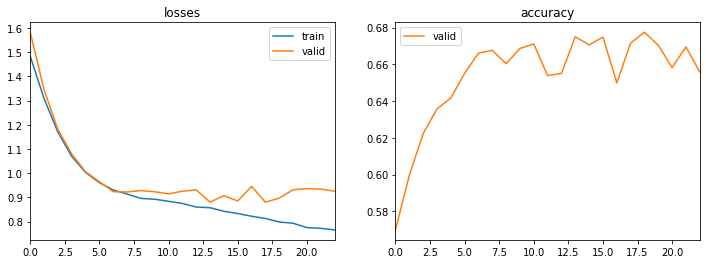

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 93%|██████████████████████████████████████████   | 28/30 [2:50:08<27:41, 830.56s/trial, best loss: 0.8791267275810242]

epoch,train_loss,valid_loss,accuracy,time
0,1.217000,1.126574,0.631871,00:50
1,0.962755,0.966998,0.671782,00:52
2,0.906156,0.918021,0.673664,00:53
3,0.884312,0.907103,0.677139,00:52
4,0.861158,0.910164,0.680276,00:52
5,0.844356,0.888890,0.676174,00:53
6,0.833045,0.875529,0.681096,00:53
7,0.822188,0.892245,0.679649,00:53
8,0.817069,0.881409,0.682255,00:53
9,0.813074,0.881854,0.680952,00:53


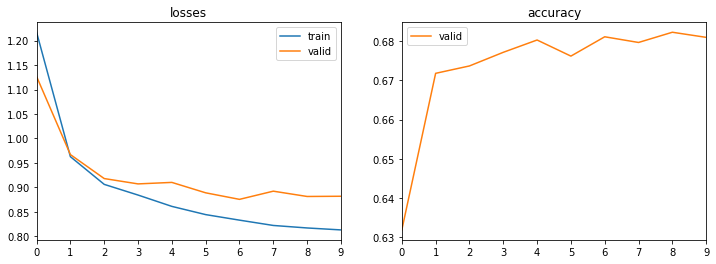

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN                                                                                                           
 97%|███████████████████████████████████████████▌ | 29/30 [2:59:23<12:28, 748.05s/trial, best loss: 0.8791267275810242]

epoch,train_loss,valid_loss,accuracy,time
0,1.382161,1.345265,0.589354,00:50
1,0.983644,0.927612,0.670334,00:52
2,0.915716,0.898257,0.680903,00:53
3,0.885768,0.909978,0.672699,00:53
4,0.870247,0.901678,0.674774,00:53
5,0.849504,0.910531,0.676029,00:53
6,0.838905,0.891690,0.677670,00:53
7,0.821842,0.890958,0.679311,00:53
8,0.819765,0.880176,0.682158,00:53
9,0.818373,0.887288,0.679359,00:53


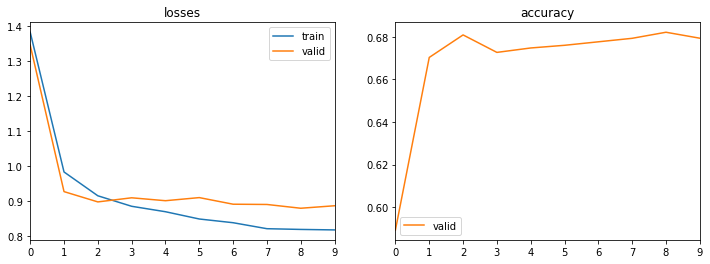

100%|█████████████████████████████████████████████| 30/30 [3:08:15<00:00, 376.50s/trial, best loss: 0.8791267275810242]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 1, 'epochs': 0, 'lr': 3, 'optimizer': 0, 'patience': 0, 'ts': 1}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = OmniScaleCNN
    k = {}
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x00000274E06BB438>, 'patience': 5, 'time_steps': 60}
OmniScaleCNN


epoch,train_loss,valid_loss,accuracy,time
0,1.305229,1.280170,0.578592,00:50
1,0.984862,0.978112,0.650403,00:52
2,0.920349,0.903834,0.669900,00:52
3,0.893103,0.902248,0.675209,00:53
4,0.878310,0.915841,0.665846,00:53
5,0.863998,0.887395,0.672796,00:53
6,0.850770,0.889892,0.675836,00:53
7,0.840245,0.892571,0.669755,00:53
8,0.833065,0.885476,0.678539,00:53
9,0.837000,0.882573,0.678153,00:53


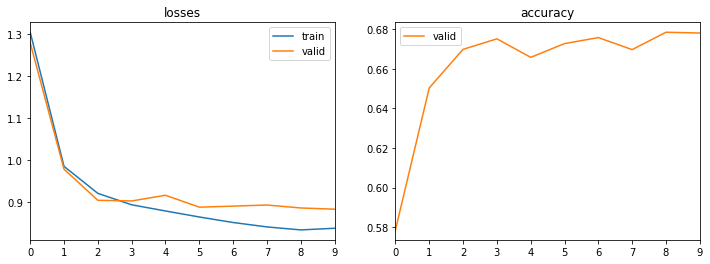

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[4.1431e-01, 3.0119e-01, 1.6893e-01, 8.5959e-02, 2.7307e-02, 2.3020e-03],
         [5.8700e-01, 1.1921e-01, 1.5153e-01, 7.2807e-02, 4.8553e-02, 2.0902e-02],
         [9.7736e-01, 1.6965e-02, 4.4607e-03, 1.0855e-03, 1.2265e-04, 5.6093e-06],
         ...,
         [9.7389e-01, 1.6778e-02, 4.9654e-03, 3.1107e-03, 1.0262e-03, 2.3315e-04],
         [9.8388e-01, 1.3348e-02, 2.2613e-03, 4.0099e-04, 9.3599e-05, 1.8545e-05],
         [8.8205e-01, 9.2235e-02, 2.0958e-02, 4.0019e-03, 6.9071e-04, 6.2963e-05]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.730177
f1 score:   0.687148


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_OmniScaleCNN', y_test_true)
np.save('y_pred_OmniScaleCNN', y_test_pred)